In [2]:
#!pip install arviz
#!pip install pymc3
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from IPython.display import Markdown as md

from scipy import stats
from scipy.special import expit as logistic
import seaborn as sns

In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

## The goal here is to compare the electric field (EF) estimations across two separate instances, once with Roast 1.1 and once with Roast 3.0 -reading data in

In [76]:
import os
os.chdir('/ECT/Bergen/Compare11vs30/')
#dfef = pd.read_csv("./2022-05-27@19-05-18_cmpef.csv", sep=",")
dfef = pd.read_csv("./2022-05-31@20-30-18_cmpef.csv", sep=",")
dfef.loc[:, ~dfef.columns.isin(['id', 'sex', 'age'])]

,Unnamed: 0,roicf,roi,mean,stdev,min,max,range,ef,ef11,ef30
0,1,EF_3rd.Ventricle,3rd-Ventricle,62.4426,13.2076,35.8359,101.0569,65.2210,72.96,72.96,62.4426
1,2,EF_4th.Ventricle,4th-Ventricle,37.6499,8.1465,25.4670,58.9128,33.4458,46.48,46.48,37.6499
2,3,EF_Brain.Stem,Brain-Stem,59.9134,13.2444,33.5857,86.4841,52.8983,67.76,67.76,59.9134
3,4,EF_CC_Anterior,CC_Anterior,90.9618,4.9549,78.9790,102.4376,23.4587,94.16,94.16,90.9618
4,5,EF_CC_Central,CC_Central,96.6774,33.6801,47.5351,145.1185,97.5834,104.64,104.64,96.6774
...,...,...,...,...,...,...,...,...,...,...,...
6906,6907,EF_Right.Pallidum,Right-Pallidum,99.1520,8.9288,78.1530,116.7636,38.6106,141.75,141.75,99.1520
6907,6908,EF_Right.Putamen,Right-Putamen,106.5002,15.0809,77.7839,144.2562,66.4723,130.77,130.77,106.5002
6908,6909,EF_Right.VentralDC,Right-VentralDC,78.3910,12.9718,51.8609,108.4424,56.5815,125.37,125.37,78.3910
6909,6910,EF_Right.vessel,Right-vessel,92.1668,10.3125,81.3804,114.8625,33.4821,103.41,103.41,92.1668


In [5]:
md("####  I had N={} subjects where both ways were calculated, this is only RUL".format(np.unique(dfef.id).size))

####  I had N=64 subjects where both ways were calculated, this is only RUL

In [6]:
datafref = dfef.iloc[np.where((dfef.ef30.notnull()) & (dfef.roicf!='EF_non.WM.hypointensities') & (dfef.roicf!='EF_WM.hypointensities'))].copy()
datafref.shape

(6783, 14)

Delta Volume

In [7]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%qtconsole

In [78]:
Nsubj = len(np.unique(datafref.id))
code = pd.DataFrame({'id':list(np.unique(datafref.id)), 'sbj':list(range(Nsubj))})
datafref['sbj'] = np.zeros(datafref.shape[0]).astype(int)

for i in range(Nsubj):
    indx = np.where(datafref.id == code.id[i])
    datafref.sbj.iloc[indx[0]] = code.sbj[i]
datafref.loc[:, ~datafref.columns.isin(['id', 'sex', 'age'])]


/tmp/ipykernel_25/3065517177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafref.sbj.iloc[indx[0]] = code.sbj[i]


,Unnamed: 0,roicf,roi,mean,stdev,min,max,range,ef,ef11,ef30,sbj,roiind
0,1,EF_3rd.Ventricle,3rd-Ventricle,62.4426,13.2076,35.8359,101.0569,65.2210,72.96,72.96,62.4426,0,0
1,2,EF_4th.Ventricle,4th-Ventricle,37.6499,8.1465,25.4670,58.9128,33.4458,46.48,46.48,37.6499,0,1
2,3,EF_Brain.Stem,Brain-Stem,59.9134,13.2444,33.5857,86.4841,52.8983,67.76,67.76,59.9134,0,2
3,4,EF_CC_Anterior,CC_Anterior,90.9618,4.9549,78.9790,102.4376,23.4587,94.16,94.16,90.9618,0,3
4,5,EF_CC_Central,CC_Central,96.6774,33.6801,47.5351,145.1185,97.5834,104.64,104.64,96.6774,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6905,6906,EF_Right.Lateral.Ventricle,Right-Lateral-Ventricle,41.8565,12.4576,21.9105,82.0907,60.1802,65.25,65.25,41.8565,63,32
6906,6907,EF_Right.Pallidum,Right-Pallidum,99.1520,8.9288,78.1530,116.7636,38.6106,141.75,141.75,99.1520,63,33
6907,6908,EF_Right.Putamen,Right-Putamen,106.5002,15.0809,77.7839,144.2562,66.4723,130.77,130.77,106.5002,63,34
6908,6909,EF_Right.VentralDC,Right-VentralDC,78.3910,12.9718,51.8609,108.4424,56.5815,125.37,125.37,78.3910,63,35


In [9]:
demog = pd.DataFrame({'age': datafref.age, 'sex': datafref.sex, 'sbj':datafref.sbj}).drop_duplicates()

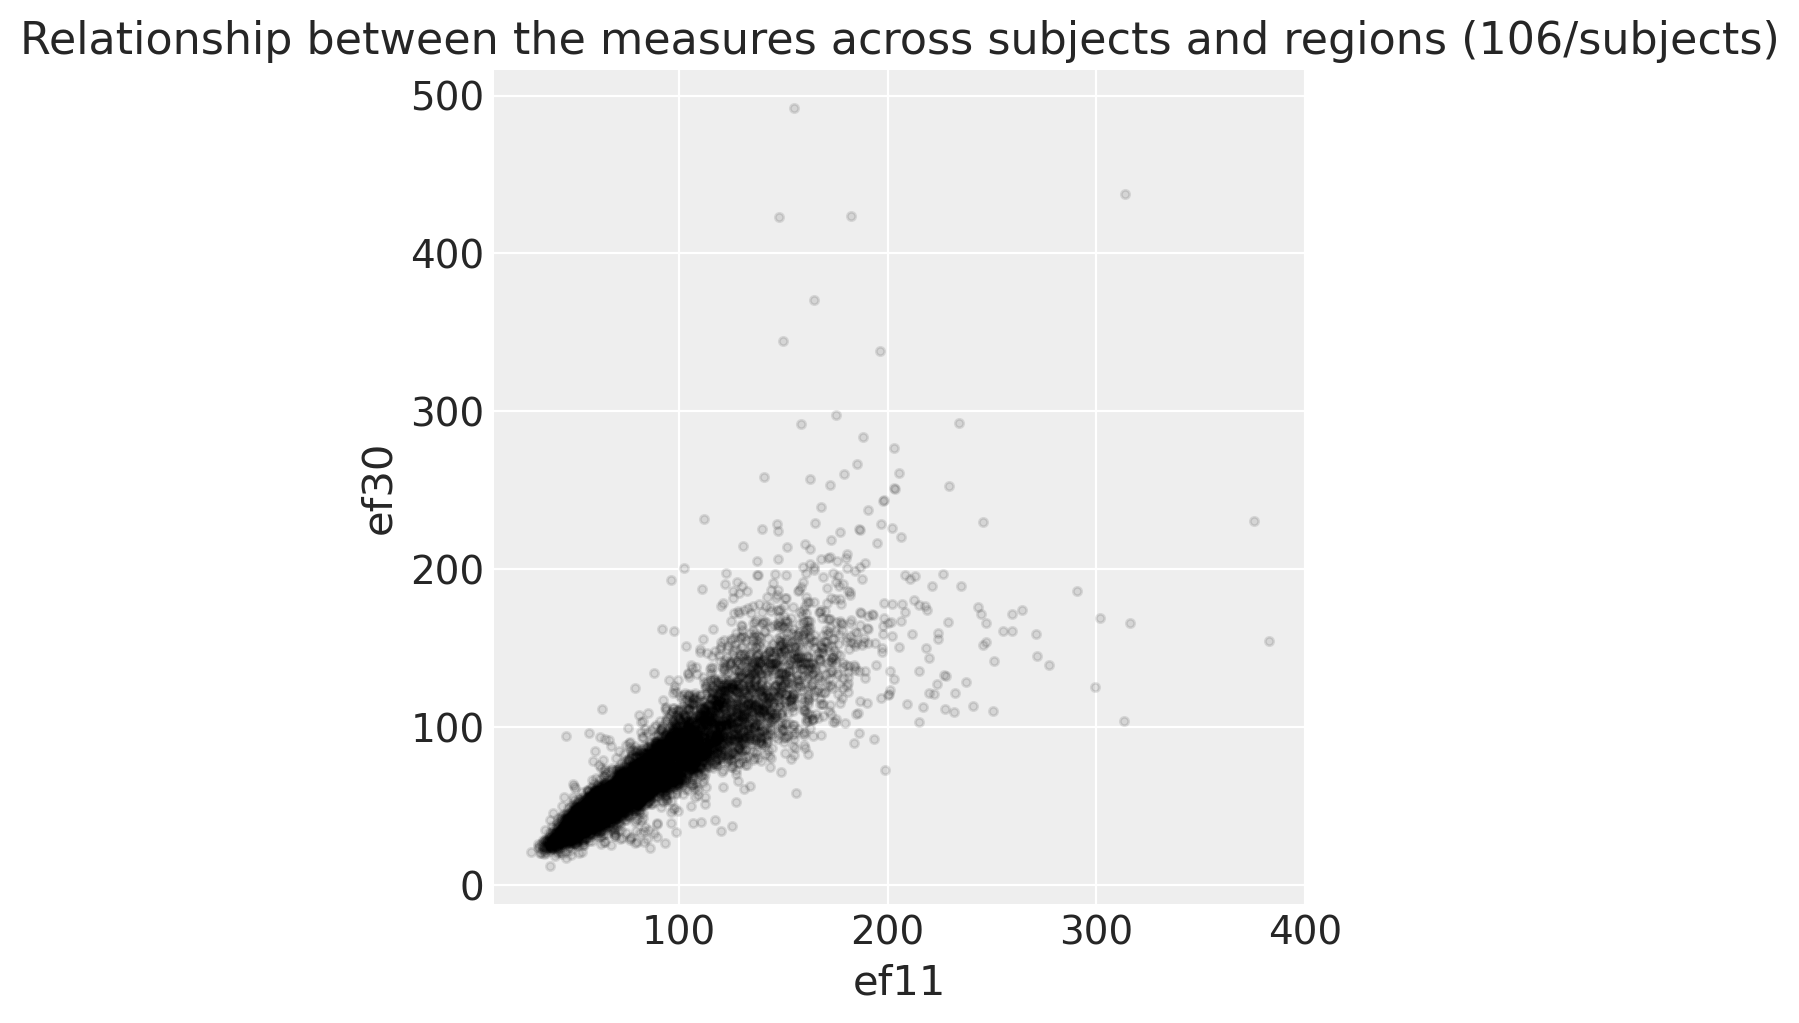

In [10]:
plt.rcParams['figure.figsize'] = (5,5);
fig, ax = plt.subplots(1,1)

ax.plot(datafref.ef11, datafref.ef30, ".k", alpha=0.1)
ax.set_xlabel("ef11")
ax.set_ylabel("ef30")
ax.set_title("Relationship between the measures across subjects and regions (106/subjects)");


### First model, when the clustering variable is the individual: $ef30 = b * ef11 + \epsilon$ - no intercept

In [11]:
sbj=datafref.sbj.astype(int).values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
#ef=ss.fit_transform(nmdata['Max_Intensity.1'].values.reshape(-1,1)).ravel()#remove extra bracket
#vol=ss.fit_transform(nmdata['dvol'].values.reshape(-1,1)).ravel() #remove extra bracket

with pm.Model() as c_1_1:
    # hyper-priors
    ef11=pm.Data('ef11', datafref.ef11)
    ef30 = pm.Data('ef30', datafref.ef30)
    #a_bar = pm.Normal("a_bar", 0.0, 100.0 )
    b_bar = pm.Normal("b_bar", 0.5,1)
    #sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)
    sigma = pm.Exponential("sigma", 0.5)
    # adaptive priors
    #a = pm.Normal("a", a_bar, sigma_a, shape=Nsubj)
    b = pm.Normal("b", b_bar, sigma_b, shape=Nsubj)
    mu = pm.Deterministic("mu", b[sbj] * ef30)
    #mu = a[sbj] + b[sbj]*nmdata['Max_Intensity.1']
    M = pm.Normal("M", mu, sigma, observed=ef11)
    
    #trace_1_2 = pm.sample(tune=3000, target_accept=0.95, random_seed=RANDOM_SEED)
    #trace_clin_1_1 = pm.sample(random_seed=RANDOM_SEED)
    #idata_clin_1_1 = az.from_pymc3(trace_clin_1_1)

In [12]:
with c_1_1:
    prior =  pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(trace)
    c_1_1_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma, sigma_b, b_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 43 seconds.


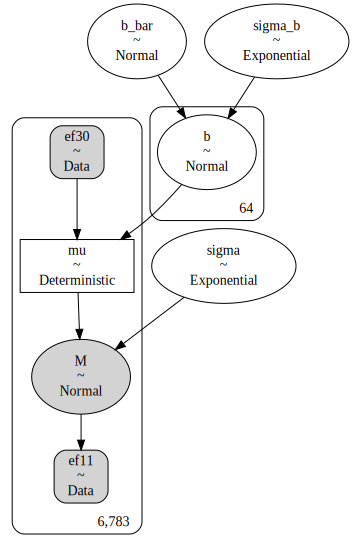

In [14]:
pm.model_graph.model_to_graphviz(c_1_1, formatting='plain')

In [15]:
ind_avg = c_1_1_idata['posterior']['b'].mean(dim=['chain','draw']).values
ind_std = c_1_1_idata['posterior']['b'].std(dim=['chain','draw']).values
ICt = pd.DataFrame({'avg': ind_avg, 'std': ind_std, 'sbj': range(len(ind_avg))})
IC = pd.merge(ICt, demog, left_on='sbj', right_on='sbj')

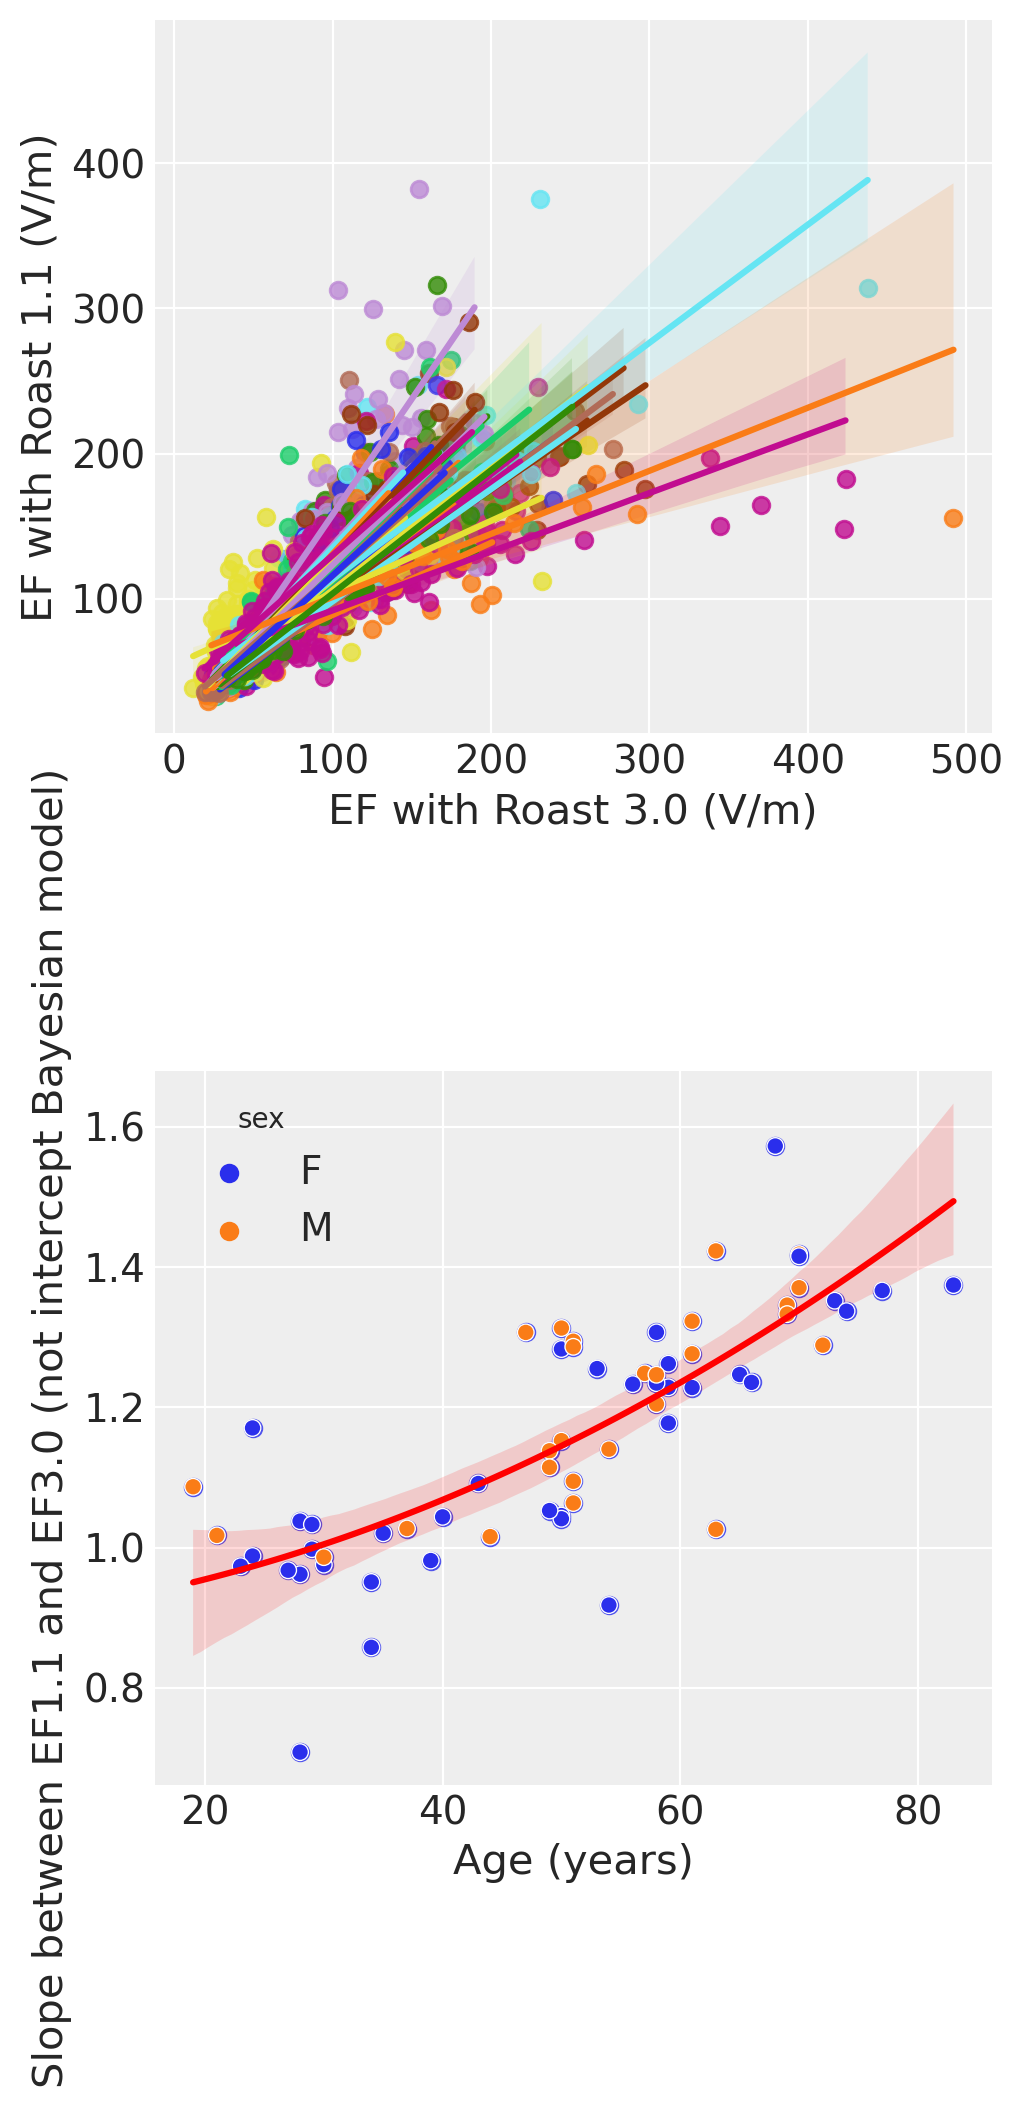

In [16]:
plt.rcParams['figure.figsize'] = (5,10);
fix, axes = plt.subplots(2,1);
for i in range(64):
    sns.regplot(data=datafref.iloc[np.where(datafref.sbj==i)], y='ef11', x='ef30', ax=axes[0]);
sns.regplot(data=IC, x='age', y='avg', line_kws={'color':'r'}, order=2, ax=axes[1]);
sns.scatterplot(data=IC, x='age', y='avg', hue='sex', ax=axes[1]);
axes[0].set_ylabel('EF with Roast 1.1 (V/m)')
axes[0].set_xlabel('EF with Roast 3.0 (V/m)')
axes[1].set_xlabel('Age (years)')
axes[1].set_ylabel('Slope between EF1.1 and EF3.0 (not intercept Bayesian model)')
plt.savefig('/ECT/Bergen/Compare11vs30/individual-differencies-are-related-to-age.pdf');
plt.show();


Conclusion
***
The model works well without intercept (note that in the figure I used the regplot function that uses intercept, that in itself shows that most of th line had intercept zero or close to that), and the slope is related to the age, meaning that in the age range between ages 20 and 50 we have a good one to one relationship. However as subjects gets older EF3.0 provides correspondingly higher values...

### Just to be complete lets model with intercept the same model above

In [64]:
sbj=datafref.sbj.astype(int).values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

with pm.Model() as c_1_1b:
    # hyper-priors
    ef11=pm.Data('ef11', datafref.ef11)
    ef30 = pm.Data('ef30', datafref.ef30)
    a_bar = pm.Normal("a_bar", 0.0, 100.0 )
    b_bar = pm.Normal("b_bar", 0.5,1)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)
    sigma = pm.Exponential("sigma", 0.5)
    # adaptive priors
    a = pm.Normal("a", a_bar, sigma_a, shape=Nsubj)
    b = pm.Normal("b", b_bar, sigma_b, shape=Nsubj)
    mu = pm.Deterministic("mu",a[sbj] + b[sbj] * ef30)
    #mu = a[sbj] + b[sbj]*nmdata['Max_Intensity.1']
    M = pm.Normal("M", mu, sigma, observed=ef11)

In [65]:
with c_1_1b:
    prior =  pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(trace)
    c_1_1b_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma, sigma_b, sigma_a, b_bar, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 77 seconds.


### Second model, when the clustering variable is the region: $ef30 = b * ef11 + \epsilon$ - no intercept

In [79]:
Nroi = len(np.unique(datafref.roicf))
coder = pd.DataFrame({'id':list(np.unique(datafref.roicf)), 'roi':list(range(Nroi))})
datafref['roiind'] = np.zeros(datafref.shape[0]).astype(int)

for i in range(Nroi):
    indx = np.where(datafref.roicf == coder.id[i])
    datafref.roiind.iloc[indx[0]] = coder.roi[i]
datafref.loc[:, ~datafref.columns.isin(['id', 'sex', 'age'])]

/tmp/ipykernel_25/2380665008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafref.roiind.iloc[indx[0]] = coder.roi[i]


,Unnamed: 0,roicf,roi,mean,stdev,min,max,range,ef,ef11,ef30,sbj,roiind
0,1,EF_3rd.Ventricle,3rd-Ventricle,62.4426,13.2076,35.8359,101.0569,65.2210,72.96,72.96,62.4426,0,0
1,2,EF_4th.Ventricle,4th-Ventricle,37.6499,8.1465,25.4670,58.9128,33.4458,46.48,46.48,37.6499,0,1
2,3,EF_Brain.Stem,Brain-Stem,59.9134,13.2444,33.5857,86.4841,52.8983,67.76,67.76,59.9134,0,2
3,4,EF_CC_Anterior,CC_Anterior,90.9618,4.9549,78.9790,102.4376,23.4587,94.16,94.16,90.9618,0,3
4,5,EF_CC_Central,CC_Central,96.6774,33.6801,47.5351,145.1185,97.5834,104.64,104.64,96.6774,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6905,6906,EF_Right.Lateral.Ventricle,Right-Lateral-Ventricle,41.8565,12.4576,21.9105,82.0907,60.1802,65.25,65.25,41.8565,63,32
6906,6907,EF_Right.Pallidum,Right-Pallidum,99.1520,8.9288,78.1530,116.7636,38.6106,141.75,141.75,99.1520,63,33
6907,6908,EF_Right.Putamen,Right-Putamen,106.5002,15.0809,77.7839,144.2562,66.4723,130.77,130.77,106.5002,63,34
6908,6909,EF_Right.VentralDC,Right-VentralDC,78.3910,12.9718,51.8609,108.4424,56.5815,125.37,125.37,78.3910,63,35


In [18]:
roiind=datafref.roiind.astype(int).values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
#ef=ss.fit_transform(nmdata['Max_Intensity.1'].values.reshape(-1,1)).ravel()#remove extra bracket
#vol=ss.fit_transform(nmdata['dvol'].values.reshape(-1,1)).ravel() #remove extra bracket

with pm.Model() as c_1_2:
    # hyper-priors
    ef11=pm.Data('ef11', datafref.ef11)
    ef30 = pm.Data('ef30', datafref.ef30)
    #a_bar = pm.Normal("a_bar", 0.0, 100.0 )
    b_bar = pm.Normal("b_bar", 0.5,1)
    #sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)
    sigma = pm.Exponential("sigma", 0.5)
    # adaptive priors
    #a = pm.Normal("a", a_bar, sigma_a, shape=Nsubj)
    b = pm.Normal("b", b_bar, sigma_b, shape=Nroi)
    mu = pm.Deterministic("mu", b[roiind] * ef30)
    #mu = a[sbj] + b[sbj]*nmdata['Max_Intensity.1']
    M = pm.Normal("M", mu, sigma, observed=ef11)

In [19]:
with c_1_2:
    prior =  pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(trace)
    c_1_2_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma, sigma_b, b_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 43 seconds.


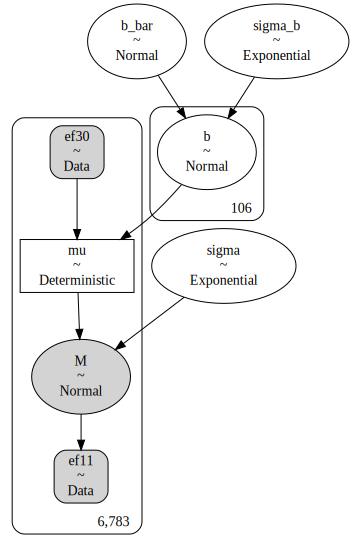

In [20]:
pm.model_graph.model_to_graphviz(c_1_2, formatting='plain')

In [21]:
cor_b = c_1_2_idata['posterior']['b'].mean(dim=['chain','draw']).values
RC = pd.DataFrame({'b':cor_b})
RC['vox']=pd.NA
RC['side']=pd.NA
RC['bols']=pd.NA
RC['roi']=pd.NA

RC.head()

,b,vox,side,bols,roi
0,1.282090,<NA>,<NA>,<NA>,<NA>
1,1.287492,<NA>,<NA>,<NA>,<NA>
2,1.251611,<NA>,<NA>,<NA>,<NA>
3,1.245433,<NA>,<NA>,<NA>,<NA>
4,1.105853,<NA>,<NA>,<NA>,<NA>


In [22]:
from nilearn import image
template_data = image.get_data('/ECT/Abbott/template.nii.gz')
template_data.shape


code = pd.read_csv('/ECT/Abbott/FsTutorial_AnatomicalROI_FreeSurferColorLUT.csv')
code.head()
coder['roiname']=coder.id.str.replace('EF_','', regex=True).str.replace('.','-', regex=True)
coder.head()

(256, 256, 256)

,Unnamed: 0,struct_index,struct_name,r,g,b,a
0,1,0,Unknown,0,0,0,0
1,2,1,Left-Cerebral-Exterior,70,130,180,0
2,3,2,Left-Cerebral-White-Matter,245,245,245,0
3,4,3,Left-Cerebral-Cortex,205,62,78,0
4,5,4,Left-Lateral-Ventricle,120,18,134,0


,id,roi,roiname
0,EF_3rd.Ventricle,0,3rd-Ventricle
1,EF_4th.Ventricle,1,4th-Ventricle
2,EF_Brain.Stem,2,Brain-Stem
3,EF_CC_Anterior,3,CC_Anterior
4,EF_CC_Central,4,CC_Central


In [23]:
import statsmodels.formula.api as sfa

In [24]:
b_data=template_data.copy();
for i in np.unique(template_data):
    #print(i)
    if (i!=0):
        ixs=np.where(template_data==i)
        regt = code.struct_name.iloc[np.where(code['struct_index']==i)]
        ixs2 = np.where(coder.roiname==regt.values[0])
        if (ixs2[0].size!=0):
            k=coder.roi.iloc[ixs2].values[0]
            #b_data[ixs]=((post['b1'][k].mean().values)*1000).round().astype('int') + ((post['a1'][k].mean().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            #b_data[ixs]=((post['a1'][k].mean().values)*1000).round().astype('int')/((post['a1'][k].std().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            #b_data[ixs]=((post['a1'][k].mean().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            b_data[ixs]=((c_1_2_idata['posterior']['b'].mean(dim=['chain','draw']).values[k])*1000).round().astype('int')
            #b_data[ixs]=((c_1_3_idata['posterior']['a'].mean(dim=['chain','draw']).values[k])*1).round().astype('int')
            RC.loc[k,'vox']=ixs[0].shape[0]
            r = sfa.ols('ef11 ~ ef30 + 0', data=datafref.iloc[np.where(datafref.roiind==k)]).fit()
            RC.loc[k,'bols']=r.params[0].astype('float64')
            RC.loc[k,'roi']=regt.values[0]
            if (pd.Series(regt.values[0]).str.contains('rh').bool() | pd.Series(regt.values[0]).str.contains('Right').bool()):
                RC.loc[k, 'side']=1
            else:
                RC.loc[k, 'side']=0
            #b_data[ixs]=((ppc['b1'][:,:,2].mean(0)[k])*1000).round().astype('int')
            
        else:
            b_data[ixs]=0 #we overwrite the template data

In [25]:
from nilearn import plotting
new_image_0 = image.new_img_like('/ECT/Abbott/template.nii.gz', b_data)
new_image_0.to_filename('/ECT/Abbott/test_im0.nii.gz')
#plotting.plot_stat_map(new_image)

#### Illustration
***
Pooling - meaning that the individual clustered variables are pooled to the mean

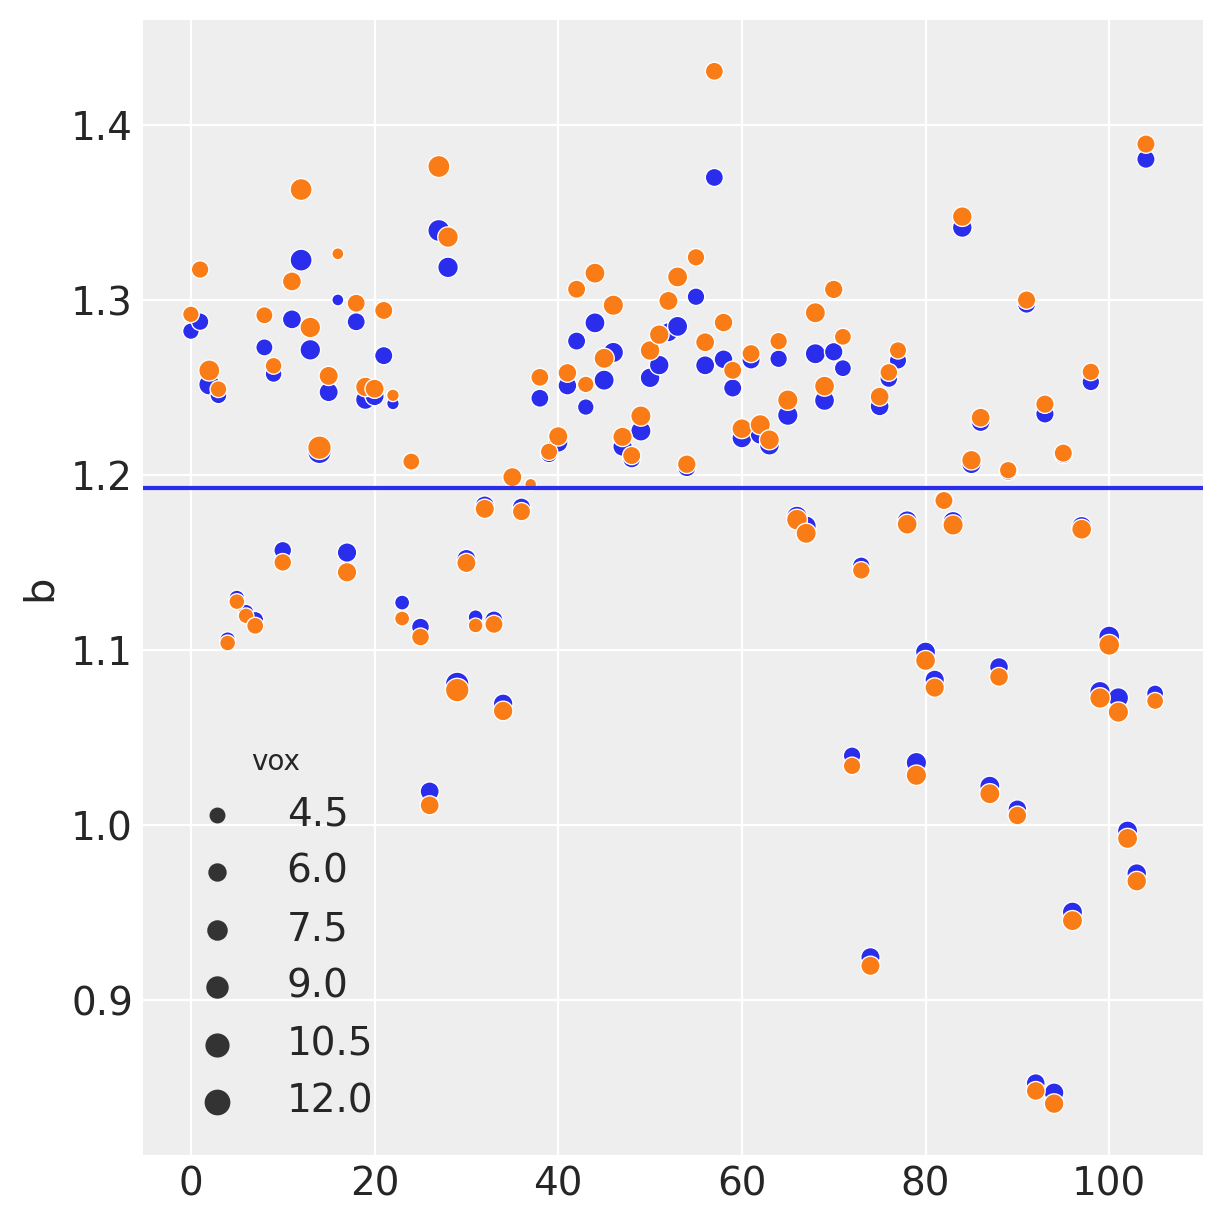

In [26]:
plt.rcParams['figure.figsize'] = (6,6);
RC['bols'] = RC['bols'].astype('float')
graph = sns.scatterplot(x=RC.index.values, y=RC.b, size=np.log(RC.vox.astype('int')));
sns.scatterplot(x=RC.index.values, y=RC.bols, size=np.log(RC.vox.astype('int')), legend=False);

graph.axhline(c_1_2_idata['posterior']['b_bar'].mean().values);

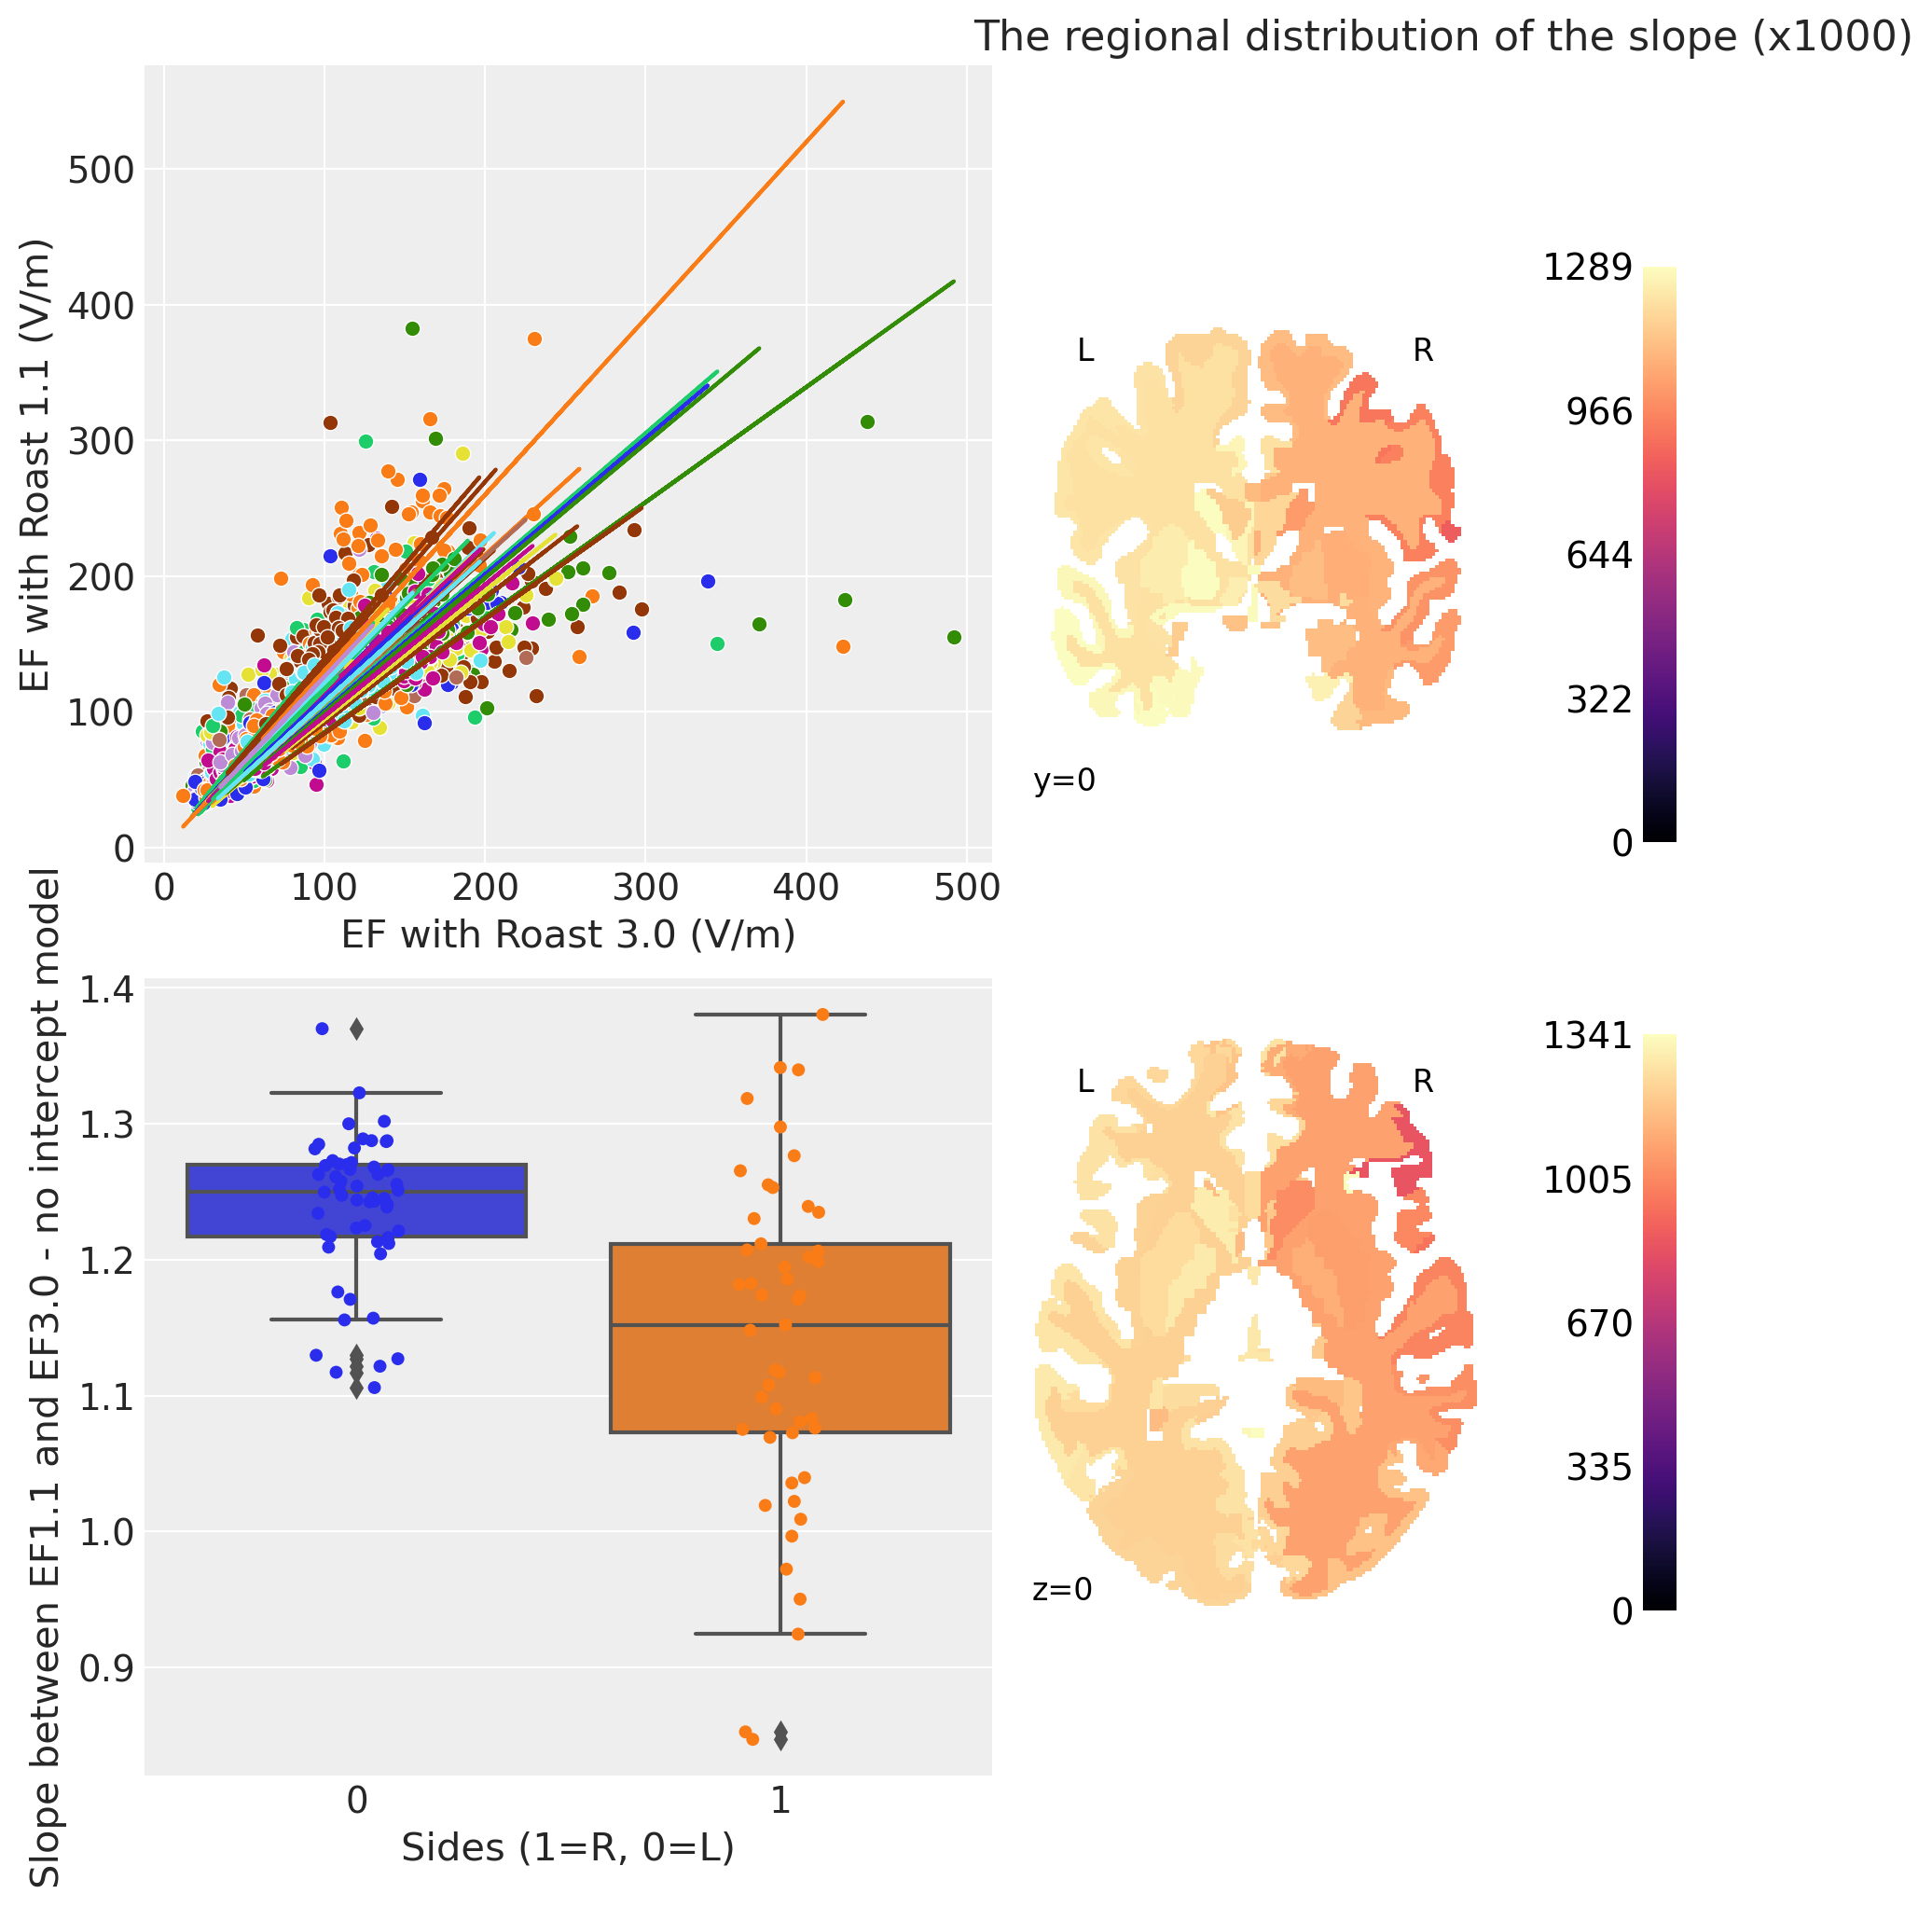

In [27]:
plt.rcParams['figure.figsize'] = (10,10);
fix, axes = plt.subplots(2,2);
for i in np.unique(datafref.roiind):
    #sns.regplot(data=datafref.iloc[np.where(datafref.roiind==i)], x='ef11', y='ef30', ax=axes[0][0], order=0);
    sns.scatterplot(data=datafref.iloc[np.where(datafref.roiind==i)], y='ef11', ax=axes[0][0], x='ef30')
    r = sfa.ols('ef11 ~ ef30 + 0', data=datafref.iloc[np.where(datafref.roiind==i)]).fit()
    axes[0][0].plot(datafref['ef30'].iloc[np.where(datafref.roiind==i)], r.fittedvalues)

sns.boxplot(data=RC, x='side', y='b', orient='v',ax=axes[1][0])
sns.stripplot(data=RC, x='side', y='b', orient='v', ax=axes[1][0])

plotting.plot_img(new_image_0, display_mode='y',cut_coords=[0], vmin=0, cmap=plt.cm.magma, threshold =0, black_bg=False, colorbar=True, draw_cross=False, cbar_tick_format="%i", axes=axes[0][1])
plotting.plot_img(new_image_0, display_mode='z',cut_coords=[0], vmin=0, cmap=plt.cm.magma, threshold =0, black_bg=False, colorbar=True, draw_cross=False, cbar_tick_format="%i", axes=axes[1][1])

axes[0][0].set_ylabel('EF with Roast 1.1 (V/m)')
axes[0][0].set_xlabel('EF with Roast 3.0 (V/m)')
axes[1][0].set_xlabel('Sides (1=R, 0=L)')
axes[1][0].set_ylabel('Slope between EF1.1 and EF3.0 - no intercept model')
axes[0][1].set_title('The regional distribution of the slope (x1000)')
#plt.savefig('/ECT/Bergen/Compare11vs30/regional-differencies-are-related-to-side.pdf');
plt.show();


### Third model, when the clustering variable is the region: $ef30 = a + b * ef11 + \epsilon$ - with intercept

In [28]:
roiind=datafref.roiind.astype(int).values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
#ef=ss.fit_transform(nmdata['Max_Intensity.1'].values.reshape(-1,1)).ravel()#remove extra bracket
#vol=ss.fit_transform(nmdata['dvol'].values.reshape(-1,1)).ravel() #remove extra bracket

with pm.Model() as c_1_3:
    # hyper-priors
    ef11=pm.Data('ef11', datafref.ef11)
    ef30 = pm.Data('ef30', datafref.ef30)
    a_bar = pm.Normal("a_bar", 0.0, 100.0 )
    b_bar = pm.Normal("b_bar", 0.5,1)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    sigma_b = pm.Exponential("sigma_b", 0.5)
    sigma = pm.Exponential("sigma", 0.5)
    # adaptive priors
    a = pm.Normal("a", a_bar, sigma_a, shape=Nroi)
    b = pm.Normal("b", b_bar, sigma_b, shape=Nroi)
    mu = pm.Deterministic("mu",a[roiind] + b[roiind] * ef30)
    #mu = a[sbj] + b[sbj]*nmdata['Max_Intensity.1']
    M = pm.Normal("M", mu, sigma, observed=ef11)

In [29]:
with c_1_3:
    prior =  pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(trace)
    c_1_3_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

/opt/conda/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma, sigma_b, sigma_a, b_bar, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 136 seconds.


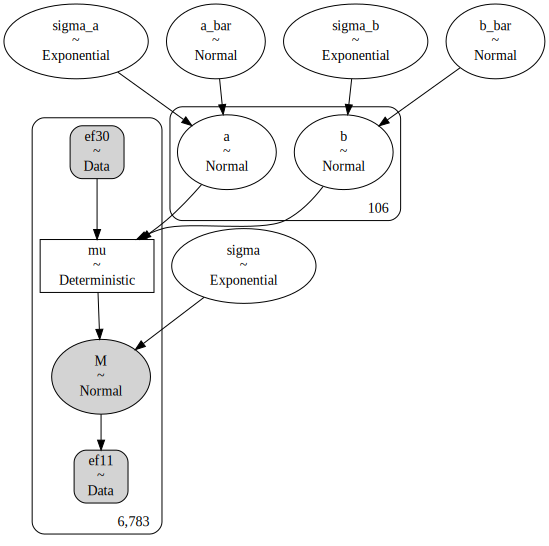

In [46]:
pm.model_graph.model_to_graphviz(c_1_3, formatting='plain')



In [50]:
cor_a = c_1_3_idata['posterior']['a'].mean(dim=['chain','draw']).values[:]
cor_b = c_1_3_idata['posterior']['b'].mean(dim=['chain','draw']).values
RC = pd.DataFrame({'a': cor_a, 'b':cor_b})
RC['vox']=pd.NA
RC['side']=pd.NA
RC.head()

,a,b,vox,side
0,54.797543,0.494073,<NA>,<NA>
1,35.199539,0.429318,<NA>,<NA>
2,48.643178,0.462811,<NA>,<NA>
3,59.259122,0.530221,<NA>,<NA>
4,71.519225,0.627460,<NA>,<NA>


In [55]:
b_data=template_data.copy();
a_data=template_data.copy();
for i in np.unique(template_data):
    #print(i)
    if (i!=0):
        ixs=np.where(template_data==i)
        regt = code.struct_name.iloc[np.where(code['struct_index']==i)]
        ixs2 = np.where(coder.roiname==regt.values[0])
        if (ixs2[0].size!=0):
            k=coder.roi.iloc[ixs2].values[0]
            #b_data[ixs]=((post['b1'][k].mean().values)*1000).round().astype('int') + ((post['a1'][k].mean().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            #b_data[ixs]=((post['a1'][k].mean().values)*1000).round().astype('int')/((post['a1'][k].std().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            #b_data[ixs]=((post['a1'][k].mean().values)*1000).round().astype('int')#here we multiply so that no need to deal integer/float issue
            b_data[ixs]=((c_1_3_idata['posterior']['b'].mean(dim=['chain','draw']).values[k])*1000).round().astype('int')
            a_data[ixs]=((c_1_3_idata['posterior']['a'].mean(dim=['chain','draw']).values[k])).round().astype('int')
            RC.loc[k,'vox']=ixs[0].shape[0]
            if (pd.Series(regt.values[0]).str.contains('rh').bool() | pd.Series(regt.values[0]).str.contains('Right').bool()):
                RC.loc[k,'side']=1
            else:
                RC.loc[k,'side']=0
            #b_data[ixs]=((ppc['b1'][:,:,2].mean(0)[k])*1000).round().astype('int')
            
        else:
            b_data[ixs]=0 #we overwrite the template data
            a_data[ixs]=0

In [56]:
from nilearn import plotting
new_image_2 = image.new_img_like('/ECT/Abbott/template.nii.gz', a_data)
new_image_2.to_filename('/ECT/Abbott/test_im2.nii.gz')
new_image_3 = image.new_img_like('/ECT/Abbott/template.nii.gz', b_data)
new_image_3.to_filename('/ECT/Abbott/test_im3.nii.gz')
#plotting.plot_stat_map(new_image)

In [60]:
#view = plotting.view_img(new_image_2, symmetric_cmap=False, vmax=140, black_bg=False)
#view

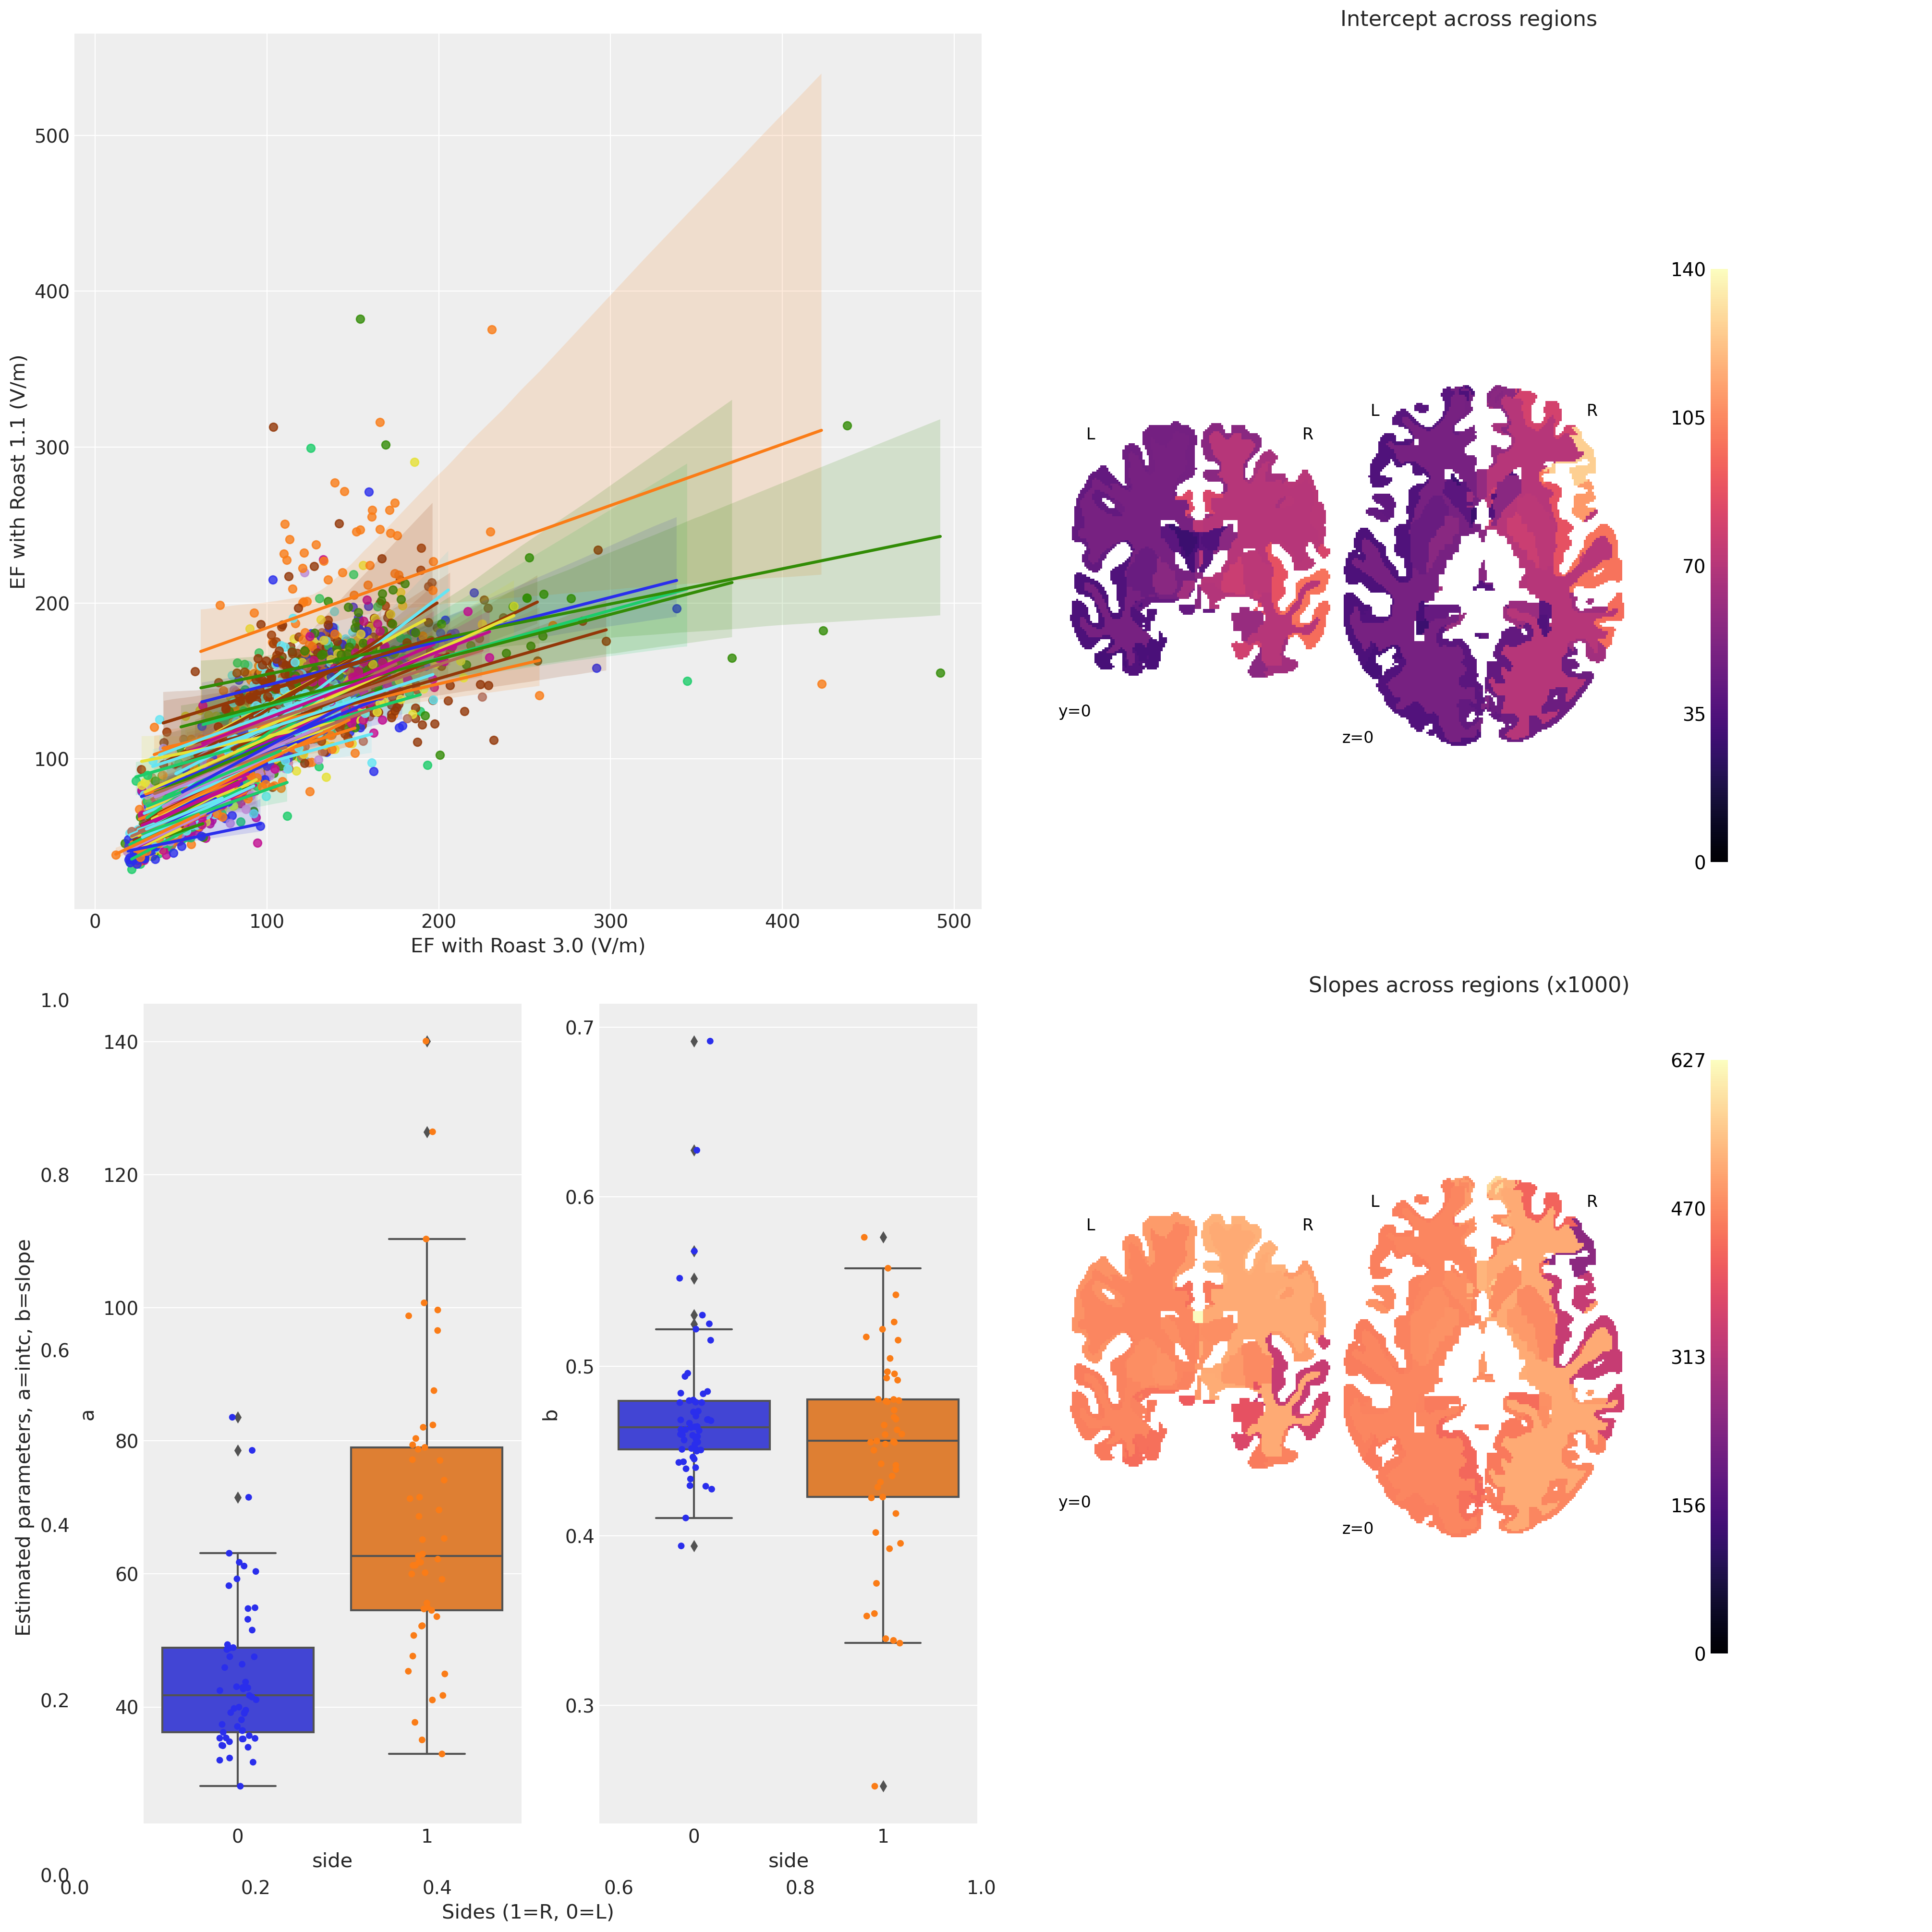

In [59]:
plt.rcParams['figure.figsize'] = (20,20);
fix, axes = plt.subplots(2,2);
gridspec = axes[1][0].get_subplotspec().get_gridspec()

for i in np.unique(datafref.roiind):
    sns.regplot(data=datafref.iloc[np.where(datafref.roiind==i)], y='ef11', x='ef30', ax=axes[0][0]);
    #sl, _, _, _ = np.linalg.lstsq([datafref.ef11.iloc[np.where(datafref.roiind==i)].values], [datafref.ef30.iloc[np.where(datafref.roiind==i)].values]);
    #plt.plot(datafref.ef11.iloc[np.where(datafref.roiind==i)].values, (datafref.ef11.iloc[np.where(datafref.roiind==i)].values)*sl);
#sns.regplot(data=IC, x='age', y='avg', line_kws={'color':'r'}, order=2, ax=axes[1]);
#sns.scatterplot(data=IC, x='age', y='avg', hue='sex', ax=axes[1]);
#sns.scatterplot(data=RC.iloc[np.where(RC.vox<30000)], x='avg', y='std', size='vox', hue='side', ax=axes[0])
subfig = fix.add_subfigure(gridspec[1,0])
axesS=subfig.subplots(1,2)
#sns.boxplot(data=RC, y='side', x='a', orient='h',ax=axes[1][0])
#sns.stripplot(data=RC, y='side', x='a', orient='h', ax=axes[1][0])
sns.boxplot(data=RC, x='side', y='a', orient='v',ax=axesS[0])
sns.stripplot(data=RC, x='side', y='a', orient='v', ax=axesS[0])
sns.boxplot(data=RC, x='side', y='b', orient='v',ax=axesS[1])
sns.stripplot(data=RC, x='side', y='b', orient='v', ax=axesS[1])

plotting.plot_img(new_image_2, display_mode='yz',cut_coords=(0,0), vmin=0, cmap=plt.cm.magma, vmax=140, threshold =0, black_bg=False, colorbar=True, draw_cross=False, cbar_tick_format="%i", axes=axes[0][1])
plotting.plot_img(new_image_3, display_mode='yz',cut_coords=(0,0), vmin=0, cmap=plt.cm.magma, threshold =0, black_bg=False, colorbar=True, draw_cross=False, cbar_tick_format="%i", axes=axes[1][1])

#plotting.plot_img(new_image, display_mode='y', cut_coords=[0], vmin=900.0, vmax=1100, threshold =700.0, black_bg=False, axes=axes[0][1])
#plotting.plot_img(new_image, display_mode='z', cut_coords=[0], vmin=900.0, vmax=1100, threshold =700.0, black_bg=False, axes=axes[1][1], colorbar=True)
axes[0][0].set_ylabel('EF with Roast 1.1 (V/m)')
axes[0][0].set_xlabel('EF with Roast 3.0 (V/m)')
axes[1][0].set_xlabel('Sides (1=R, 0=L)')
axes[1][0].set_ylabel('Estimated parameters, a=intc, b=slope')

axes[0][1].set_title('Intercept across regions')
axes[1][1].set_title('Slopes across regions (x1000)')

#axes[1].set_ylabel('Slope between EF1.1 and EF3.0')
plt.savefig('/ECT/Bergen/Compare11vs30/regional-differencies-aAb-are-related-to-side.pdf');
plt.show();

### Conclusions
***
There is a relatively good corespondance between Roast 1.1 and 3.0 given that we use different pipelines (Freesurfer, and also 5% or 1% outlier exclusions, etc).
Two things keep in mind:
1. if we model clustering around subject that is slightly better (see below), but in this case the relationship deviates from slope=1.0 as as age increases, meaning that $EF1.1 \neq EF3.0$, but EF1.1 slightly overestimates compared to EF3.0 
2. if we model clustering around regions there is definitely an intercept, meaning there is a bias, but this is expected as there is less variance in a region EF...-here the Right side closer to the electrodes the better the 1:1 relationship.

At this point there is no reason to think one version is better than the other, only validation on realy biological sample could help. 
Next step do the estimation for all the sample (N~multiple hundreds)


### Compare models
***
Using WAIC (Widely applicable information criterion) the with intercept looks better

In [69]:
%%capture cap

com = az.compare({'model_clust-ind-wo-i': c_1_1_idata, 'model_clust-ind-w-i': c_1_1b_idata, 'model_wo-i': c_1_2_idata, 'model_w-i': c_1_3_idata}, method='BB-pseudo-BMA')

In [71]:
com

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_clust-ind-w-i,0,54833.139683,285.420494,0.000000,NaN,529.015139,0.000000,True,deviance
model_w-i,1,54854.325666,287.647565,21.185983,NaN,645.606722,467.142771,True,deviance
model_clust-ind-wo-i,2,57964.484881,247.542092,3131.345198,NaN,437.485322,333.682816,True,deviance
model_wo-i,3,59783.408446,238.466065,4950.268763,0.0,496.001474,623.716389,True,deviance


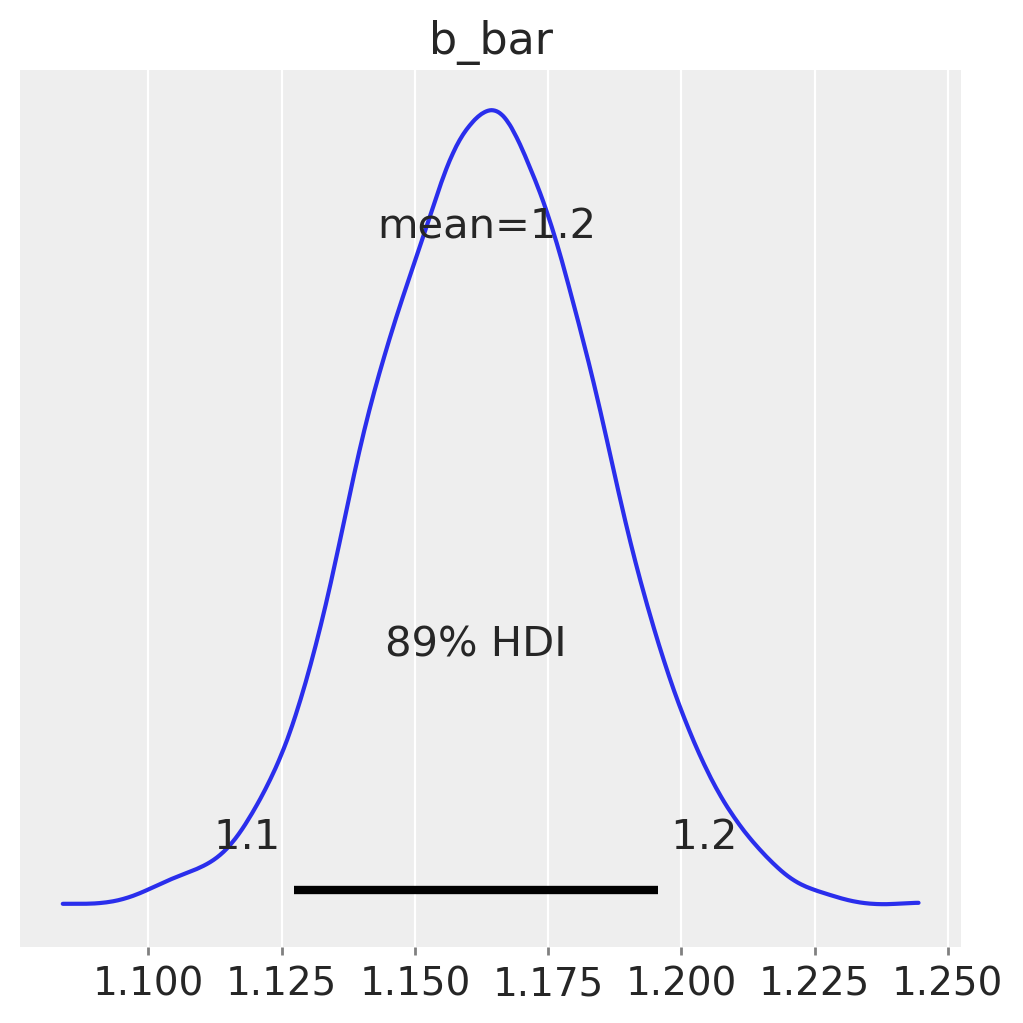

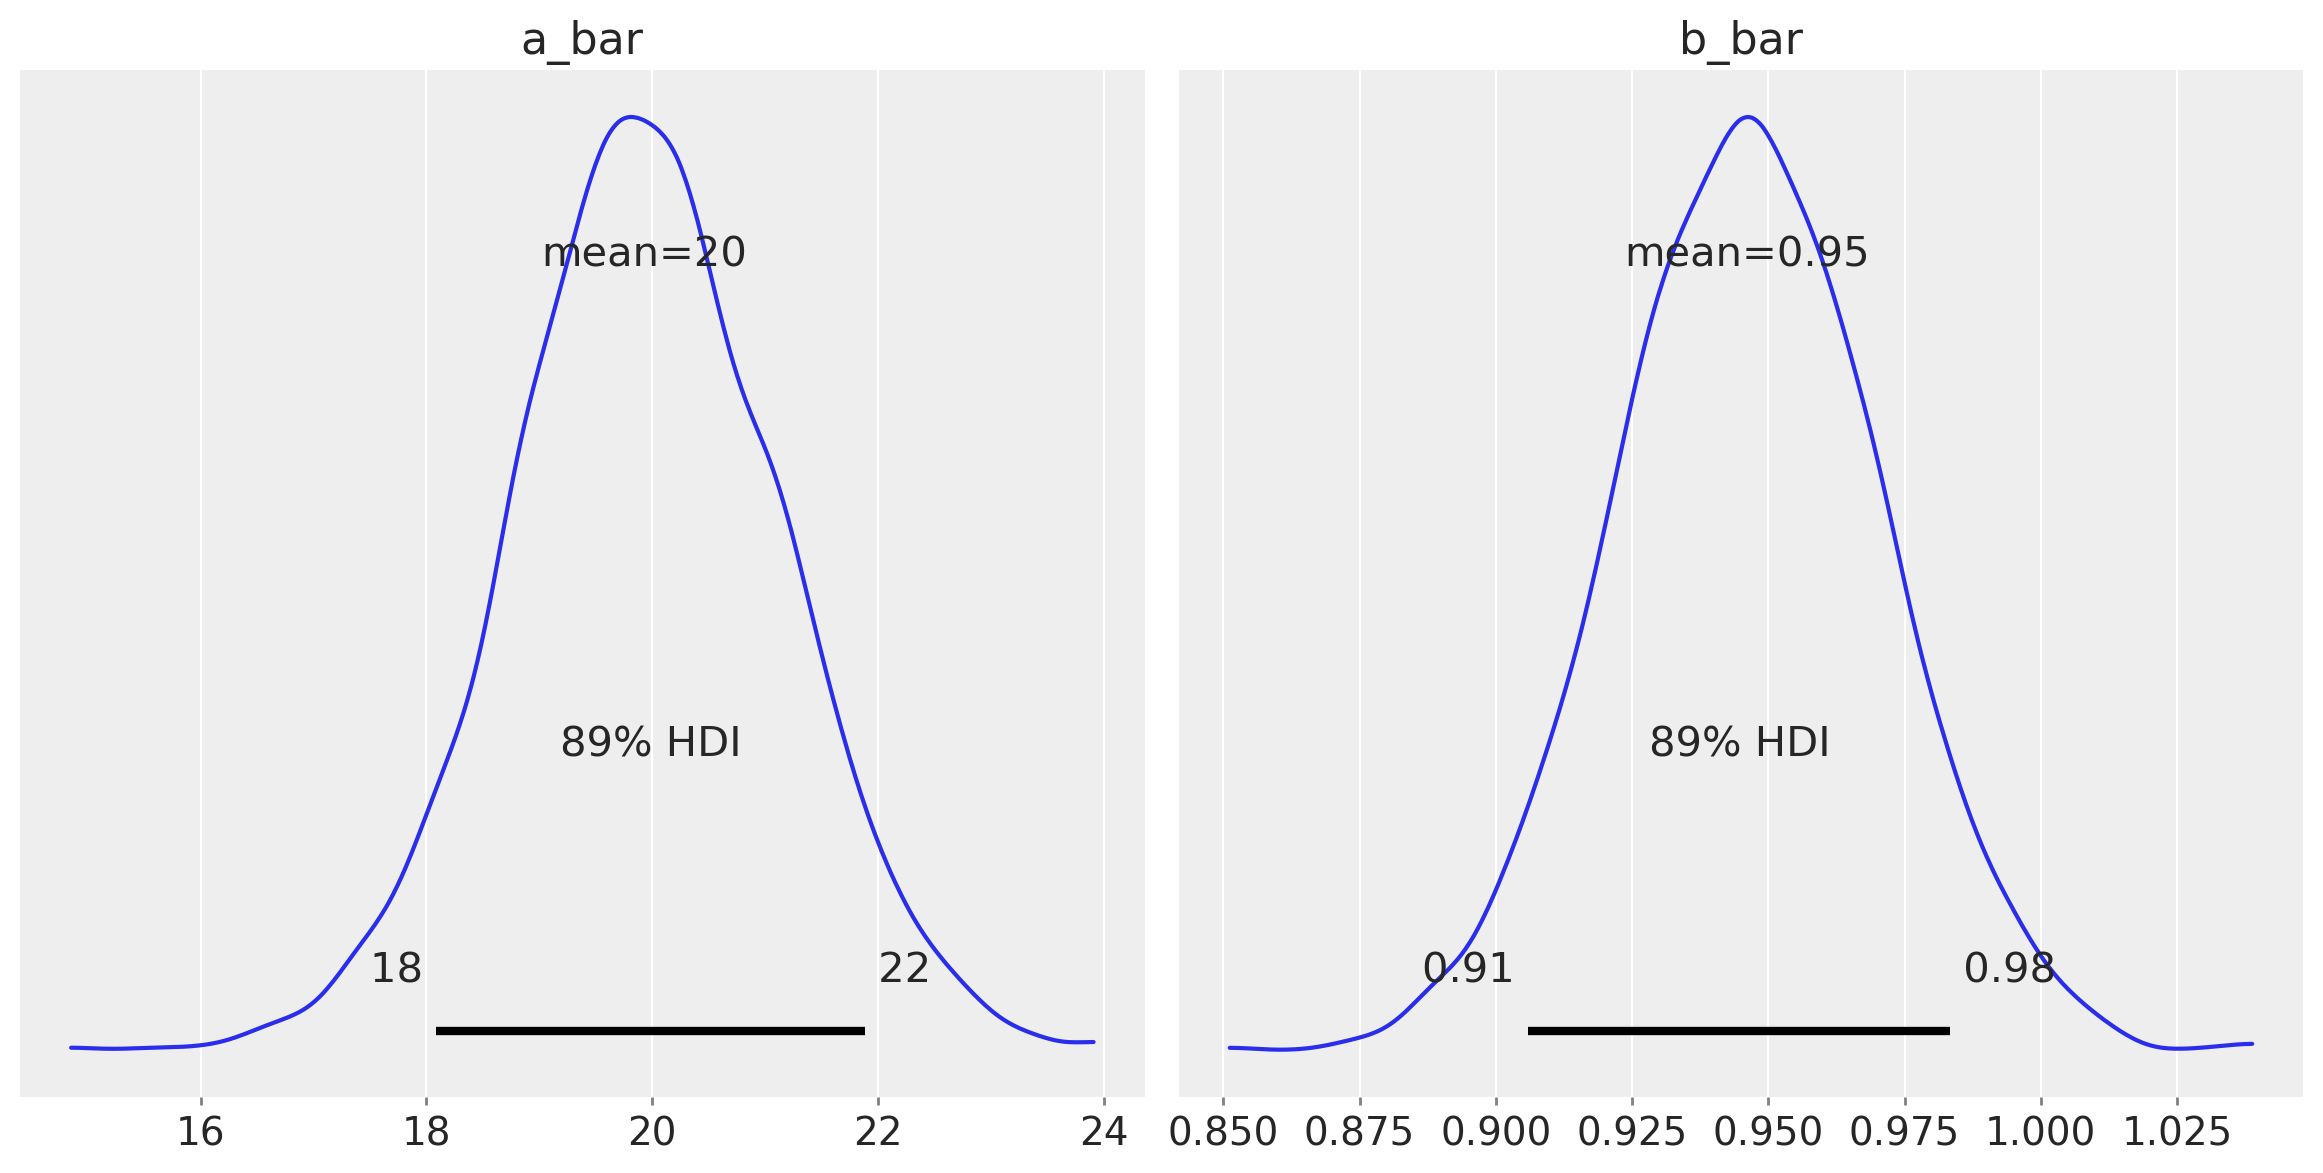

In [74]:
plt.rcParams['figure.figsize'] = (5,5);
az.plot_posterior(c_1_1_idata, var_names=['b_bar']);
az.plot_posterior(c_1_1b_idata, var_names=['a_bar','b_bar']);


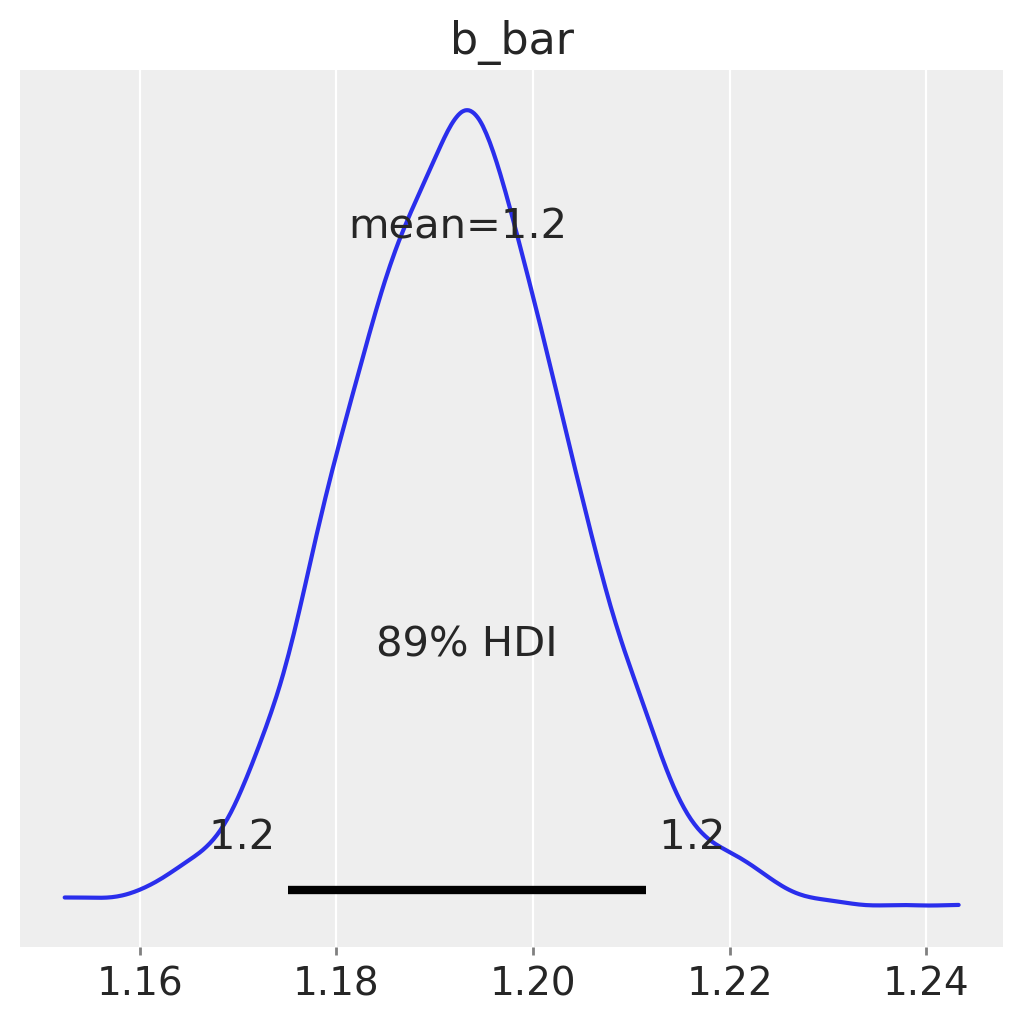

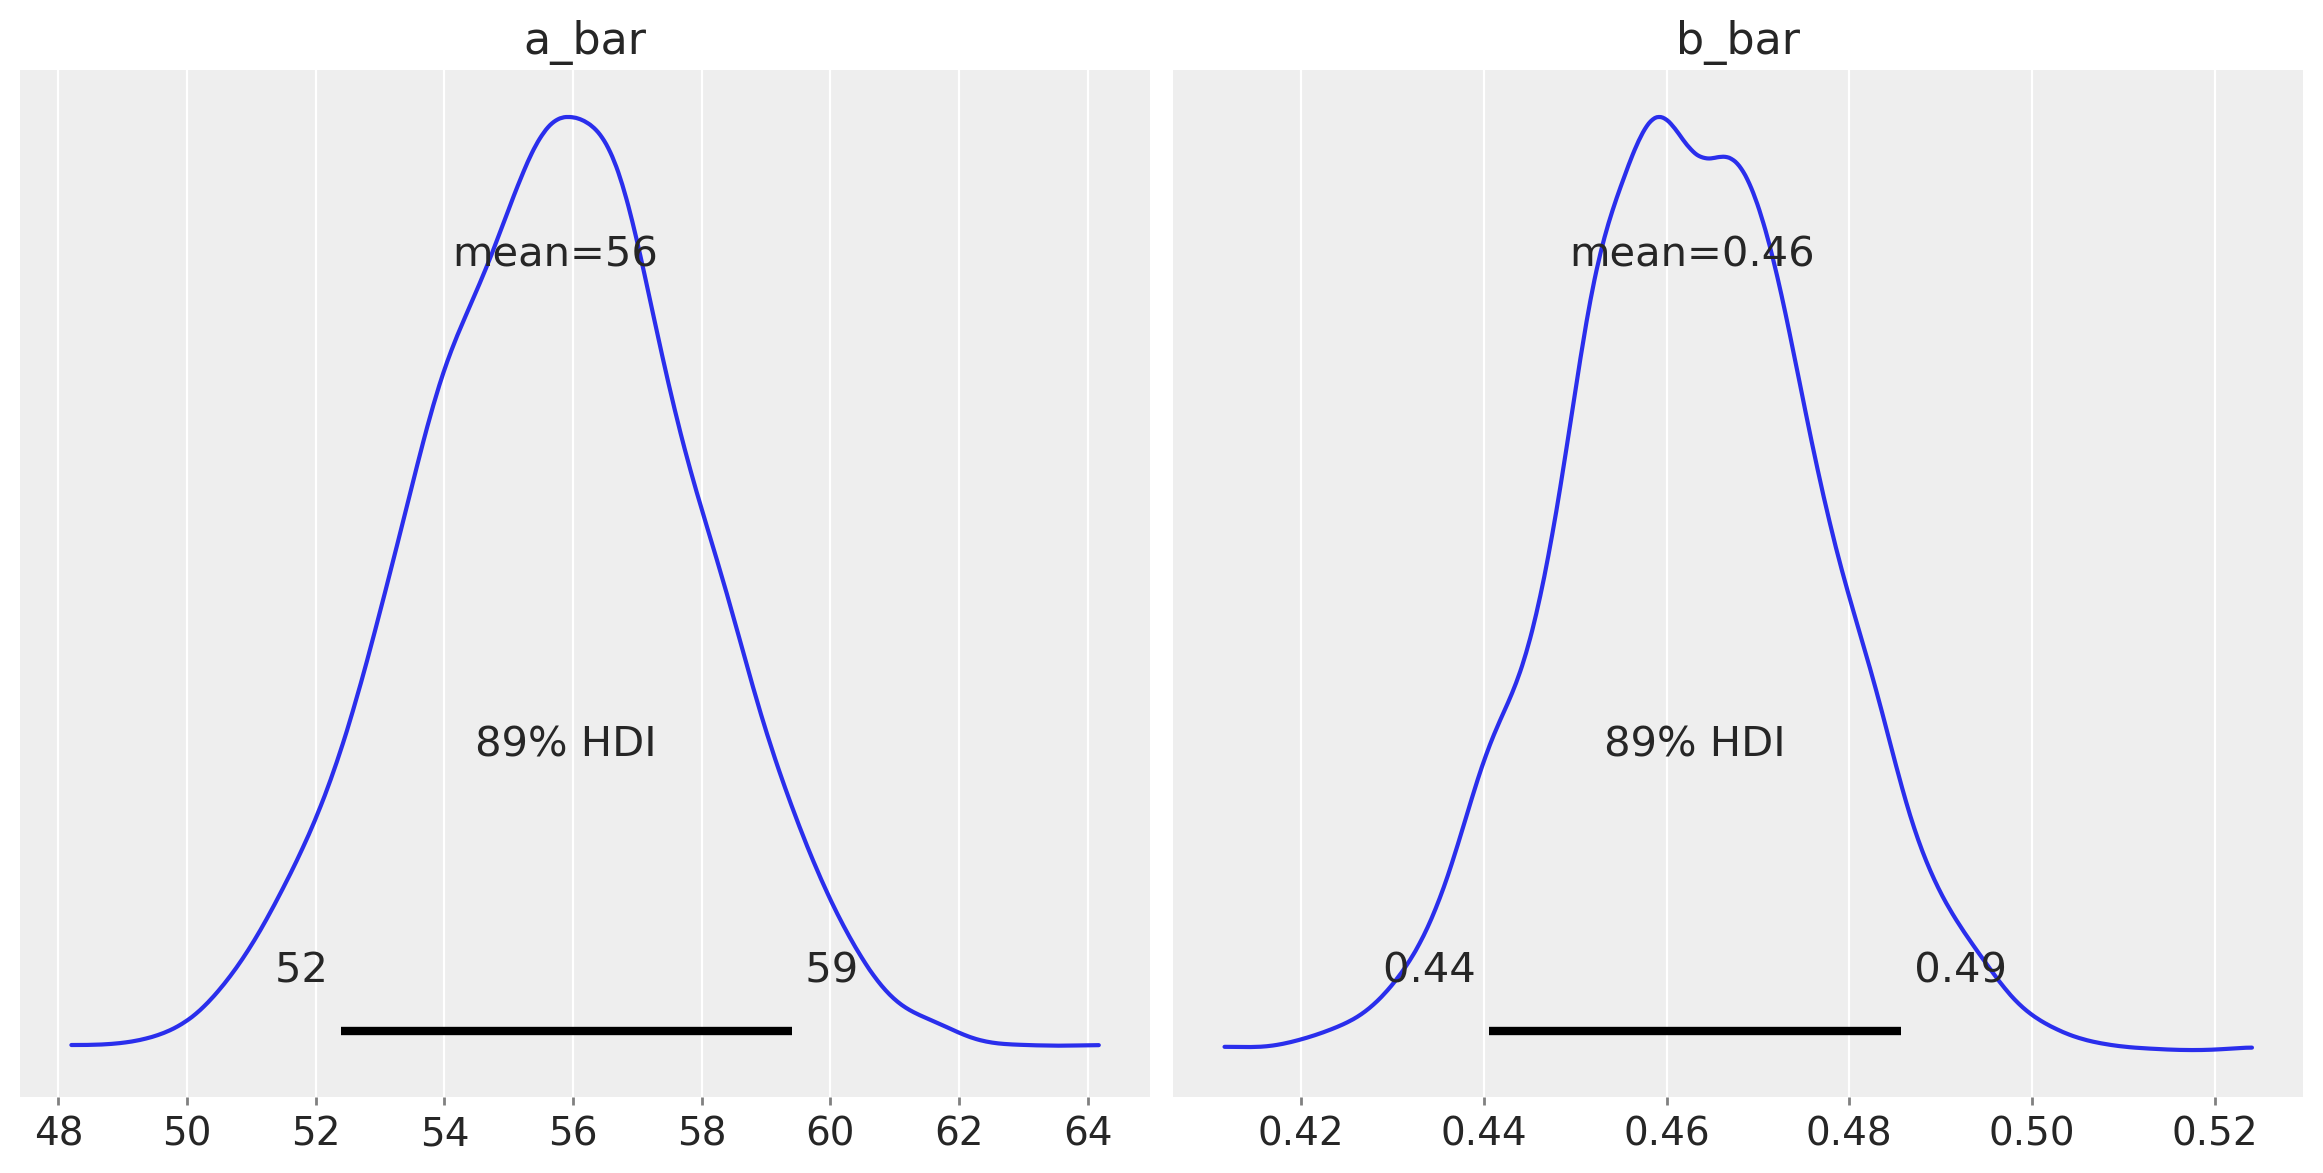

In [75]:
plt.rcParams['figure.figsize'] = (5,5);
az.plot_posterior(c_1_2_idata, var_names=['b_bar']);
az.plot_posterior(c_1_3_idata, var_names=['a_bar','b_bar']);